In [3]:
import os
os.environ["SDSS_LOCAL_SAS_MIRROR"]="/data/jdli/sdss/"
os.environ["RESULTS_VERS"]="dr17"
os.environ["GAIA_TOOLS_DATA"]="/data/jdli/gaia/"

%matplotlib inline
%load_ext autoreload
%autoreload 2
from pylab import *

from astropy.table import Table, join
from astropy.io import fits
from tqdm import tqdm
import numpy as np


In [91]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14

import numpy as np
import pandas as pd
from tqdm import tqdm
import cmasher as cmr

from matplotlib import colors

In [4]:
from astroquery.gaia import Gaia


In [5]:
Gaia.login()
# jli06
# zwHD5BFFcbT@HZW

INFO: Login to gaia TAP server [astroquery.gaia.core]


User:  jli06
Password:  ········


401 Error 401:
<!doctype html><html lang="en"><head><title>HTTP Status 401 – Unauthorized</title><style type="text/css">body {font-family:Tahoma,Arial,sans-serif;} h1, h2, h3, b {color:white;background-color:#525D76;} h1 {font-size:22px;} h2 {font-size:16px;} h3 {font-size:14px;} p {font-size:12px;} a {color:black;} .line {height:1px;background-color:#525D76;border:none;}</style></head><body><h1>HTTP Status 401 – Unauthorized</h1><hr class="line" /><p><b>Type</b> Status Report</p><p><b>Message</b> Unauthorized</p><p><b>Description</b> The request has not been applied because it lacks valid authentication credentials for the target resource.</p><hr class="line" /><h3>Apache Tomcat/8.5.57</h3></body></html>


ERROR: Error logging in TAP server [astroquery.gaia.core]


In [8]:
cat = Table.read(os.environ["SDSS_LOCAL_SAS_MIRROR"]+"/dr17/ap17_gdr3_tm_wise_tr.fits")
cat.info

names = [name for name in cat.colnames if len(cat[name].shape)<=1]
df_raw = cat[names].to_pandas()


In [9]:
df_raw.columns

Index(['APOGEE_ID', 'TELESCOPE', 'FIELD', 'ALT_ID', 'RA', 'DEC', 'GLON',
       'GLAT', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR', 'AK_TARG',
       'AK_TARG_METHOD', 'AK_WISE', 'SFD_EBV', 'SNR', 'SNREV', 'STARFLAG',
       'STARFLAGS', 'ANDFLAG', 'ANDFLAGS', 'VHELIO_AVG', 'VSCATTER', 'VERR',
       'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
       'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC',
       'GAIAEDR3_PMDEC_ERROR', 'GAIAEDR3_PHOT_G_MEAN_MAG',
       'GAIAEDR3_PHOT_BP_MEAN_MAG', 'GAIAEDR3_PHOT_RP_MEAN_MAG',
       'GAIAEDR3_DR2_RADIAL_VELOCITY', 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR',
       'GAIAEDR3_R_MED_GEO', 'GAIAEDR3_R_LO_GEO', 'GAIAEDR3_R_HI_GEO',
       'GAIAEDR3_R_MED_PHOTOGEO', 'GAIAEDR3_R_LO_PHOTOGEO',
       'GAIAEDR3_R_HI_PHOTOGEO', 'ASPCAPFLAG', 'ASPCAPFLAGS', 'TEFF',
       'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'M_H', 'M_H_ERR', 'ALPHA_M',
       'ALPHA_M_ERR', 'VSINI', 'source_id', 'visibility_periods_used', 'ruwe',
       'AllWISE'

In [10]:
df_raw['qph_w1'] = [s.decode('utf-8')[0] for s in df_raw['qph']]
df_raw['qph_w2'] = [s.decode('utf-8')[1] for s in df_raw['qph']]


In [11]:
def chunks(lst, n):
    ""
    "Split an input list into multiple chunks of size =< n"
    ""
    for i in range(0, len(lst), n):
        yield lst[i:i+n]
        
        
dl_threshold = 5000               # DataLink server threshold. It is not possible to download products for more than 5000 sources in one single call.
ids          = cat['GAIAEDR3_SOURCE_ID']
ids_chunks   = list(chunks(ids, dl_threshold))
datalink_all = []


print(f'* Input list contains {len(ids)} source_IDs')
print(f'* This list is split into {len(ids_chunks)} chunks of <= {dl_threshold} elements each')



* Input list contains 88325 source_IDs
* This list is split into 18 chunks of <= 5000 elements each


In [13]:
# retrieval_type = 'XP_SAMPLED'  # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
retrieval_type = 'XP_CONTINUOUS'
data_structure = 'COMBINED'   # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
data_release   = 'Gaia DR3' # Options are: 'Gaia DR3' (default), 'Gaia DR2'
dl_key         = f'{retrieval_type}_{data_structure}.xml'

datalink_all = []

# dl_keys  = [inp for inp in datalink.keys()]
# dl_keys.sort()

ii = 0
for chunk in ids_chunks:
    ii+=1
    print(f'Downloading Chunk #{ii}; N_files = {len(chunk)}')
    datalink  = Gaia.load_data(ids=chunk,
                               data_release = data_release, 
                               retrieval_type=retrieval_type, format='votable',
                               data_structure=data_structure)
    
    datalink_all.append(datalink)

In [14]:
product_list_tb  = [item for sublist in datalink_all for item in sublist[dl_key]]
# product_list_ids = [item.get_field_by_id("source_id") for sublist in datalink_all for item in sublist[dl_key]]
product_list_ids = [sid for sublist in datalink_all for item in sublist[dl_key] for sid in item.array["source_id"].data]



In [15]:
from tqdm import tqdm
N_COEFF = 55


bp_coef = []
rp_coef = []
e_bp_coef, e_rp_coef = [], []

i = 0
for kk,tab in tqdm(enumerate(product_list_tb)):
    
    bp_coefficients         = np.array([d.data for d in tab.array["bp_coefficients"]]).reshape(-1, N_COEFF)
    bp_coefficients_errors  = np.array([d.data for d in tab.array["bp_coefficient_errors"]]).reshape(-1, N_COEFF)


    rp_coefficients         = np.array([d.data for d in tab.array["rp_coefficients"]]).reshape(-1, N_COEFF)
    rp_coefficients_errors  = np.array([d.data for d in tab.array["rp_coefficient_errors"]]).reshape(-1, N_COEFF)
    
    bp_coef.append(bp_coefficients)
    rp_coef.append(rp_coefficients)
    
    e_bp_coef.append(bp_coefficients_errors)
    e_rp_coef.append(rp_coefficients_errors)
    
    
bp_coef = np.vstack(tuple([_ for _ in bp_coef]))
rp_coef = np.vstack(tuple([_ for _ in rp_coef]))
e_bp_coef = np.vstack(tuple([_ for _ in e_bp_coef]))
e_rp_coef = np.vstack(tuple([_ for _ in e_rp_coef]))

print(bp_coef.shape, rp_coef.shape, e_bp_coef.shape, e_rp_coef.shape)
print(len(product_list_ids))

18it [00:01, 10.78it/s]

(82492, 55) (82492, 55) (82492, 55) (82492, 55)
82492


In [46]:
df_raw.columns

Index(['APOGEE_ID', 'TELESCOPE', 'FIELD', 'ALT_ID', 'RA', 'DEC', 'GLON',
       'GLAT', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR', 'AK_TARG',
       'AK_TARG_METHOD', 'AK_WISE', 'SFD_EBV', 'SNR', 'SNREV', 'STARFLAG',
       'STARFLAGS', 'ANDFLAG', 'ANDFLAGS', 'VHELIO_AVG', 'VSCATTER', 'VERR',
       'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
       'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC',
       'GAIAEDR3_PMDEC_ERROR', 'GAIAEDR3_PHOT_G_MEAN_MAG',
       'GAIAEDR3_PHOT_BP_MEAN_MAG', 'GAIAEDR3_PHOT_RP_MEAN_MAG',
       'GAIAEDR3_DR2_RADIAL_VELOCITY', 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR',
       'GAIAEDR3_R_MED_GEO', 'GAIAEDR3_R_LO_GEO', 'GAIAEDR3_R_HI_GEO',
       'GAIAEDR3_R_MED_PHOTOGEO', 'GAIAEDR3_R_LO_PHOTOGEO',
       'GAIAEDR3_R_HI_PHOTOGEO', 'ASPCAPFLAG', 'ASPCAPFLAGS', 'TEFF',
       'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'M_H', 'M_H_ERR', 'ALPHA_M',
       'ALPHA_M_ERR', 'VSINI', 'source_id', 'visibility_periods_used', 'ruwe',
       'AllWISE'

In [47]:
import pandas as pd

df_xpcontinous = pd.DataFrame(
    {'source_id':product_list_ids, 'bp_coef':bp_coef.tolist(), 
     'e_bp_coef':e_bp_coef.tolist(), 'rp_coef':rp_coef.tolist(),  
     'e_rp_coef':e_rp_coef.tolist()}
)

df_xpcontinous = df_xpcontinous.merge(
    df_raw[[
        'GAIAEDR3_SOURCE_ID', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR', 
        'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR', 'GAIAEDR3_PHOT_G_MEAN_MAG',
       'GAIAEDR3_PHOT_BP_MEAN_MAG', 'GAIAEDR3_PHOT_RP_MEAN_MAG',
        'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'M_H', 'M_H_ERR', 'ALPHA_M', 'ALPHA_M_ERR',
        'W1mag', 'W2mag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'e_W1mag', 'e_W2mag',
        'qph_w1', 'qph_w2', 
           ]], 
    left_on='source_id', right_on='GAIAEDR3_SOURCE_ID', how='left')

print(df_xpcontinous.shape)

(82492, 36)


In [48]:
df_xpcontinous.head()

,source_id,bp_coef,e_bp_coef,rp_coef,e_rp_coef,GAIAEDR3_SOURCE_ID,J,J_ERR,H,H_ERR,...,W2mag,W3mag,W4mag,Jmag,Hmag,Kmag,e_W1mag,e_W2mag,qph_w1,qph_w2
0,422596679964513792,"[15165.617946592545, -1721.5016893849738, -167...","[7.185272693634033, 6.069084644317627, 6.33240...","[17227.957026839962, -1817.282988426649, -35.5...","[3.2178711891174316, 2.9909799098968506, 2.942...",422596679964513792,10.905,0.023,10.635,0.030,...,10.447,10.375,8.930,10.905,10.635,10.483,0.023,0.020,A,A
1,421077597267551104,"[13599.182856690079, -397.6847455603626, -483....","[6.693983554840088, 5.800073623657227, 6.00819...","[18101.9083107185, -1344.4251895509801, 52.458...","[3.442444086074829, 3.2309682369232178, 3.1673...",421077597267551104,10.664,0.023,10.132,0.030,...,10.032,10.003,8.720,10.664,10.132,10.018,0.023,0.020,A,A
2,429530195985183744,"[15412.297633348438, 3440.7151938417455, -587....","[10.154775619506836, 8.61961555480957, 9.59582...","[44553.06993052493, 5313.520665960605, 469.455...","[7.244657516479492, 6.703298568725586, 6.77615...",429530195985183744,9.013,0.063,8.029,0.057,...,7.682,7.568,7.633,9.013,8.029,7.745,0.043,0.033,A,A
3,531274466534134272,"[11042.53980160163, 1756.0749511773506, -504.9...","[6.528904438018799, 5.74321174621582, 6.193324...","[25325.560168087042, 1598.6201026072165, 255.0...","[4.657858371734619, 4.302825450897217, 4.38440...",531274466534134272,9.795,0.023,9.057,0.027,...,8.801,8.687,8.239,9.795,9.057,8.872,0.024,0.020,A,A
4,429484398762416384,"[6755.127466723138, 689.5728622336802, -366.30...","[4.12352991104126, 3.4456048011779785, 3.73355...","[12617.548849293404, 166.12303526139428, 32.47...","[2.762612819671631, 2.5833723545074463, 2.5796...",429484398762416384,10.702,0.026,10.022,0.032,...,9.776,9.697,9.351,10.702,10.022,9.842,0.023,0.020,A,A


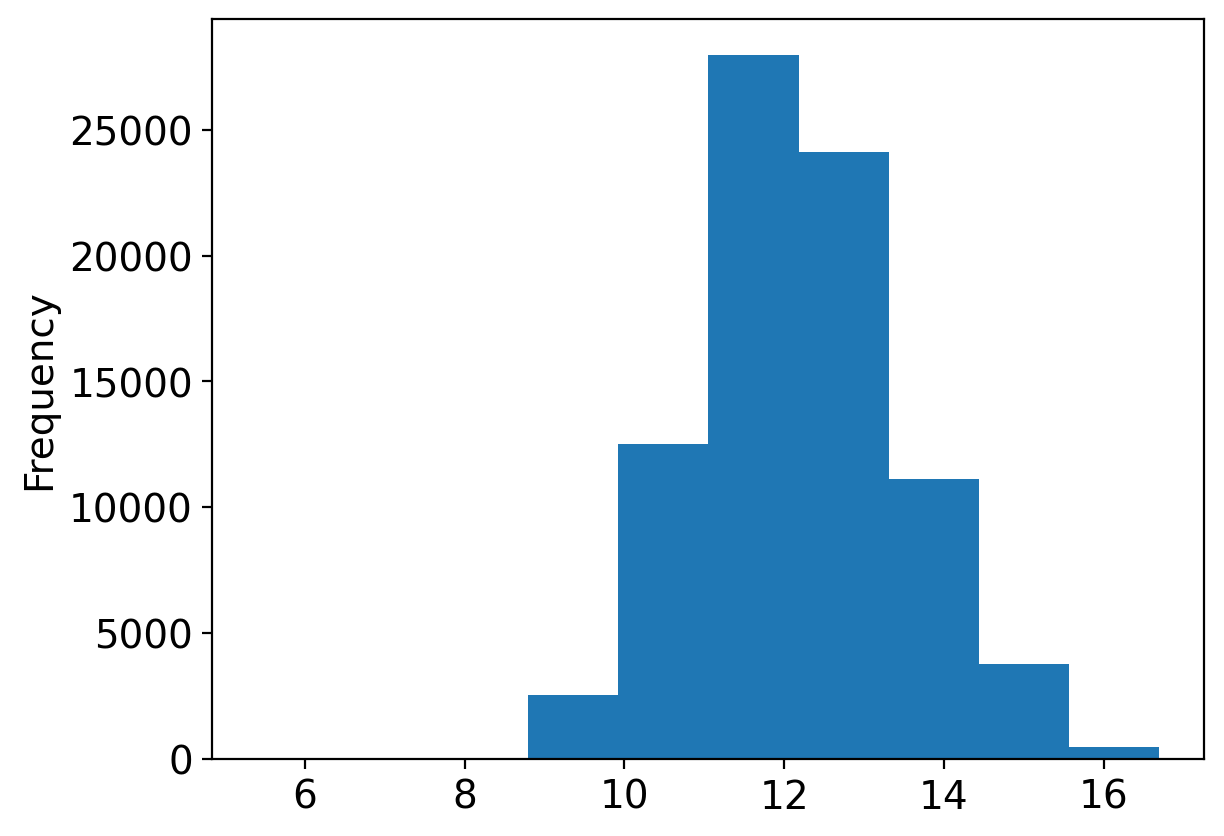

In [90]:
df_xpcontinous['GAIAEDR3_PHOT_G_MEAN_MAG'].plot(kind='hist');

In [105]:
xp_df = pd.DataFrame(np.c_[bp_coef, e_bp_coef, rp_coef, e_rp_coef, 
                           df_xpcontinous['GAIAEDR3_PHOT_G_MEAN_MAG'].values])

In [132]:
n_coef = 55

G_grids = np.arange(8, 17., 0.5)
xp_df = xp_df.assign(G_bin=pd.cut(xp_df[220], bins=G_grids))

xp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,212,213,214,215,216,217,218,219,220,G_bin
0,15165.617947,-1721.501689,-167.860661,12.035603,-91.302121,134.429094,15.451303,-25.012316,41.990611,-4.171834,...,0.834998,0.726893,0.798239,0.747030,0.599333,0.509623,0.228293,0.130959,12.2209,"(12.0, 12.5]"
1,13599.182857,-397.684746,-483.706231,95.741802,-94.978468,31.141919,-72.421863,-12.716429,-2.695854,4.248003,...,1.135843,1.086340,0.993323,0.905395,0.701949,0.628067,0.249728,0.139219,12.2759,"(12.0, 12.5]"
2,15412.297633,3440.715194,-587.869737,-470.031510,-28.718481,204.161960,-14.630041,-18.985553,-4.238522,35.796560,...,2.090823,2.006931,2.083970,1.783136,1.754322,1.667047,0.546630,0.374219,11.6607,"(11.5, 12.0]"
3,11042.539802,1756.074951,-504.921144,-204.022572,-109.331983,168.677809,-22.229473,-20.245222,8.365150,22.117896,...,1.422624,1.193505,1.316508,1.150660,1.176413,1.055172,0.338948,0.179489,12.1861,"(12.0, 12.5]"
4,6755.127467,689.572862,-366.305129,-26.703579,-48.114755,92.183562,-10.603467,-12.508226,-1.878700,8.530864,...,0.865138,0.771935,0.744752,0.730584,0.634958,0.581454,0.189072,0.090346,12.8517,"(12.5, 13.0]"


In [133]:
bp_coef_snr_map = np.zeros([len(G_grids)-1, n_coef])
rp_coef_snr_map = np.zeros([len(G_grids)-1, n_coef])
num_coeff = np.linspace(1,55,55)


for i, (g, group) in enumerate(xp_df.groupby('G_bin')):
    
    for j in range(n_coef):
        
        bp_coef_snr_map[i,j] = np.median(np.abs(group[j])/group[j+n_coef])
        rp_coef_snr_map[i,j] = np.median(np.abs(group[j+2*n_coef])/group[j+3*n_coef])
        

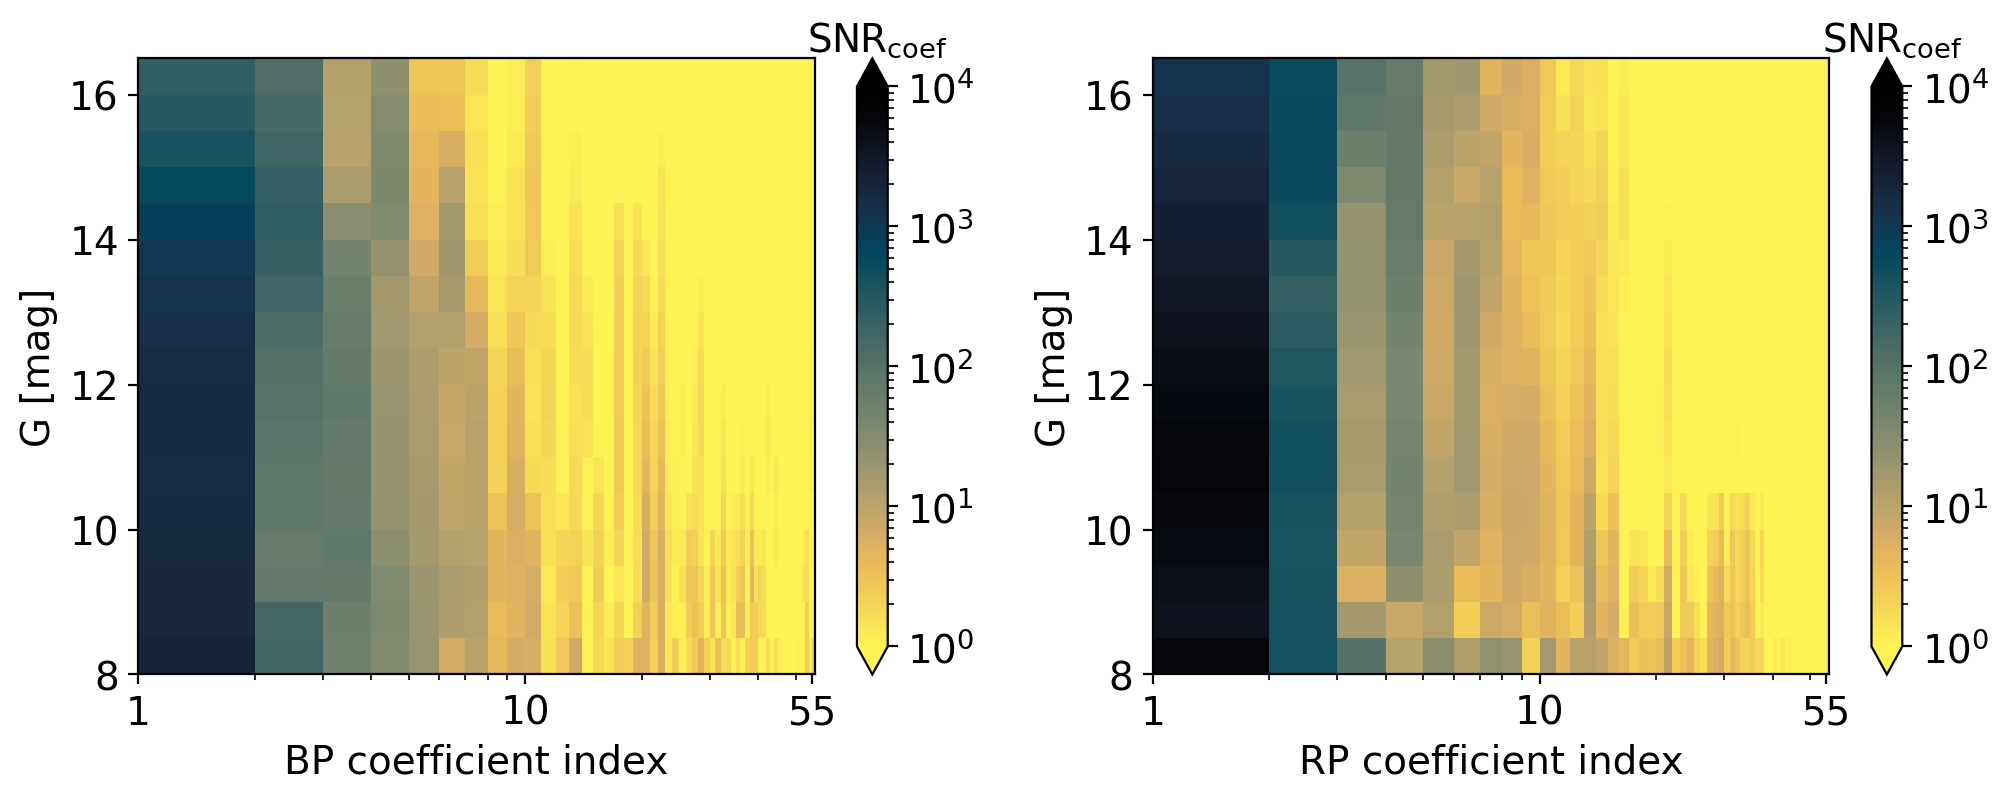

In [175]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
num_coeff_grid = np.linspace(1,56,56)


xx, yy = np.meshgrid(num_coeff_grid, G_grids)
ax1, ax2 = axs.ravel()
img1 = ax1.pcolormesh(
    xx, yy, bp_coef_snr_map, norm=colors.LogNorm(vmin=1, vmax=1e4), 
    cmap='cmr.eclipse_r'
)
img2 = ax2.pcolormesh(
    xx, yy, rp_coef_snr_map, norm=colors.LogNorm(vmin=1, vmax=1e4), 
    cmap='cmr.eclipse_r'
)
ax2.set_xscale('log')
ax1.set_xscale('log')

ax1.set_xticks([1, 10, 55]);
ax2.set_xticks([1, 10, 55]);
ax1.set_xticklabels([1, 10, 55]);
ax2.set_xticklabels([1, 10, 55]);


clb1 = fig.colorbar(img1, ax=ax1, extend='both');
clb2 = fig.colorbar(img2, ax=ax2, extend='both');

clb1.set_label(r"SNR$_{\rm coef}$", rotation=0, y=1.12, labelpad=-35)
clb2.set_label(r"SNR$_{\rm coef}$", rotation=0, y=1.12, labelpad=-35)

ax1.set_xlabel("BP coefficient index");
ax1.set_ylabel("G [mag]");

ax2.set_xlabel("RP coefficient index");
ax2.set_ylabel("G [mag]");


In [123]:
# cmap = plt.get_cmap('cmr.rainforest')
# norm = colors.Normalize(vmin=10, vmax=17)

# c_Gmag = [cmap(norm(G)) for G in df_xpcontinous['GAIAEDR3_PHOT_G_MEAN_MAG']]

In [49]:
data_dir = "/data/jdli/gaia/"

mask = (df_xpcontinous['J']>-1) & (df_xpcontinous['J']<20.) &\
        (df_xpcontinous['H']>-0.) & (df_xpcontinous['H']<15.) &\
        (df_xpcontinous['K']>-1.) & (df_xpcontinous['K']<20.) &\
        (df_xpcontinous['M_H']>-3) & (df_xpcontinous['M_H']<1) &\
        (df_xpcontinous['TEFF']>2000) & (df_xpcontinous['TEFF']<7000) &\
        (df_xpcontinous['ALPHA_M']>-1) & (df_xpcontinous['ALPHA_M']<1) &\
        (df_xpcontinous['W1mag']>2) & (df_xpcontinous['W1mag']<20.) &\
        (df_xpcontinous['W2mag']>2) & (df_xpcontinous['W2mag']<20.) &\
        (df_xpcontinous['qph_w1']=='A') & (df_xpcontinous['qph_w2']=='A')

print(df_xpcontinous[mask].shape)

data_cont ={'bp_coef':np.array([np.array(_) for _ in df_xpcontinous['bp_coef'].values[mask]]).reshape(len(df_xpcontinous[mask]), -1), 
            'rp_coef':np.array([np.array(_) for _ in df_xpcontinous['rp_coef'].values[mask]]).reshape(len(df_xpcontinous[mask]), -1), 
            'e_bp_coef':np.array([np.array(_) for _ in df_xpcontinous['e_bp_coef'].values[mask]]).reshape(len(df_xpcontinous[mask]), -1),
            'e_rp_coef':np.array([np.array(_) for _ in df_xpcontinous['e_rp_coef'].values[mask]]).reshape(len(df_xpcontinous[mask]), -1),
            'df':df_xpcontinous[mask]}

np.save(data_dir+"ap17_wise_xpcont_cut.npy", data_cont)

(81309, 36)


In [50]:


data_cont = np.load(data_dir+"ap17_wise_xpcont_cut.npy", allow_pickle=True).item()
data_cont.keys()



dict_keys(['bp_coef', 'rp_coef', 'e_bp_coef', 'e_rp_coef', 'df'])

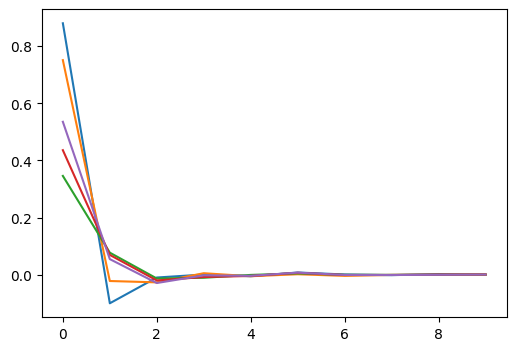

In [244]:
idx_lst = [0, 10, 100, 1000, 10000]
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# from sklearn import preprocessing
# scaler_bp = preprocessing.RobustScaler()
# scaler_rp = preprocessing.RobustScaler()

# scaler_bp.fit(bp_coef[mask])
# scaler_rp.fit(rp_coef[mask])
norm = data_cont['rp_coef'][:,0]
for i,idx in enumerate(idx_lst):
    # yy_bp = scaler_bp.transform(bp_coef[mask])[idx]
    # yy_rp = scaler_bp.transform(rp_coef[mask])[idx]
    # print(yy_bp, yy_rp)
    xx = np.arange(10)
    ax.plot(
        xx, 
        data_cont['bp_coef'][i,:10]/norm[i]
        # np.log10(data_cont['bp_coef'][i,:8]+6*1e4),
    )
    # ax.plot(
    #     xx, np.log10(data_cont['rp_coef'][i,:8]+6*1e4),
    # )

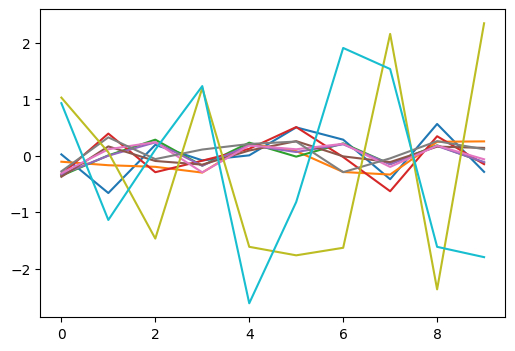

In [51]:
from sklearn import preprocessing


idx_lst = [0, 10, 100, 1000, 10000]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

scaler_bp = preprocessing.RobustScaler(quantile_range=(14., 86.))
scaler_rp = preprocessing.RobustScaler(quantile_range=(14., 86.))

norm_bp = scaler_bp.fit_transform(np.log10(data_cont['bp_coef']+6*1e4))
norm_rp = scaler_rp.fit_transform(np.log10(data_cont['rp_coef']+6*1e4))

import joblib

joblib.dump(scaler_bp, 'models/scaler_bp.gz')
joblib.dump(scaler_rp, 'models/scaler_rp.gz')


for i,idx in enumerate(idx_lst):
    # print(yy_bp, yy_rp)
    x_len = 10
    xx = np.arange(x_len)
    ax.plot(
        xx, norm_bp[idx,:x_len]
    )
    ax.plot(
        xx, norm_rp[idx,:x_len]
    )

In [52]:
# norm_bp = data_cont['bp_coef'] * norm[:,None]**-1
# norm_rp = data_cont['rp_coef'] * norm[:,None]**-1

data_cont.update(norm_bp_coef=norm_bp,
                 norm_rp_coef=norm_rp
                )

np.save(data_dir+"ap17_wise_xpcont_cut.npy", data_cont)



In [53]:
data_cont.keys()


dict_keys(['bp_coef', 'rp_coef', 'e_bp_coef', 'e_rp_coef', 'df', 'norm_bp_coef', 'norm_rp_coef'])

In [178]:
def l2norm(y):
    return np.sqrt(np.sum(y**2, axis=1))


snr_bp = l2norm(data_cont['bp_coef'])/l2norm(data_cont['e_bp_coef'])
snr_rp = l2norm(data_cont['rp_coef'])/l2norm(data_cont['e_rp_coef'])


snr_bp_10 = l2norm(data_cont['bp_coef'][:,:10])/l2norm(data_cont['e_bp_coef'][:,:10])
snr_rp_10 = l2norm(data_cont['rp_coef'][:,:10])/l2norm(data_cont['e_rp_coef'][:,:10])


snr_bp_55 = l2norm(data_cont['bp_coef'][:,10:55])/l2norm(data_cont['e_bp_coef'][:,10:55])
snr_rp_55 = l2norm(data_cont['rp_coef'][:,10:55])/l2norm(data_cont['e_rp_coef'][:,10:55])


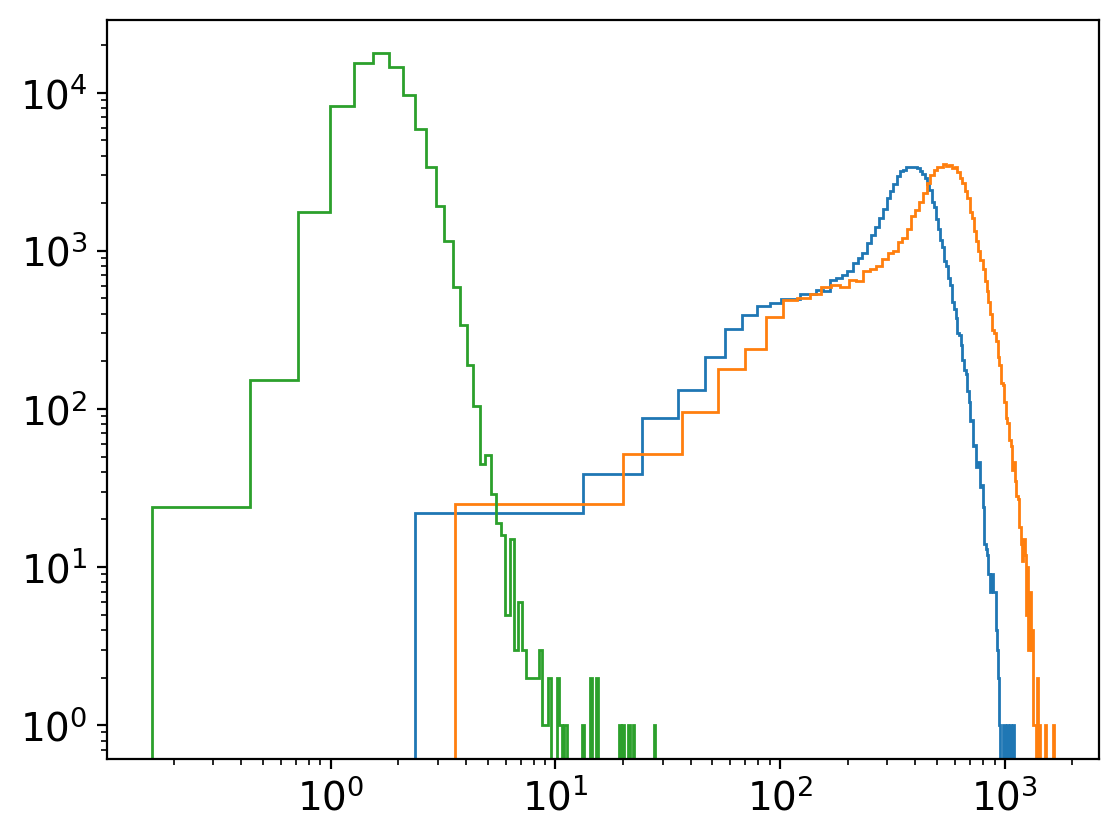

In [183]:
plt.hist(snr_bp, histtype='step', bins=100);
plt.hist(snr_bp_10, histtype='step', bins=100);
plt.hist(snr_bp_55, histtype='step', bins=100);
plt.xscale('log')
plt.yscale('log')

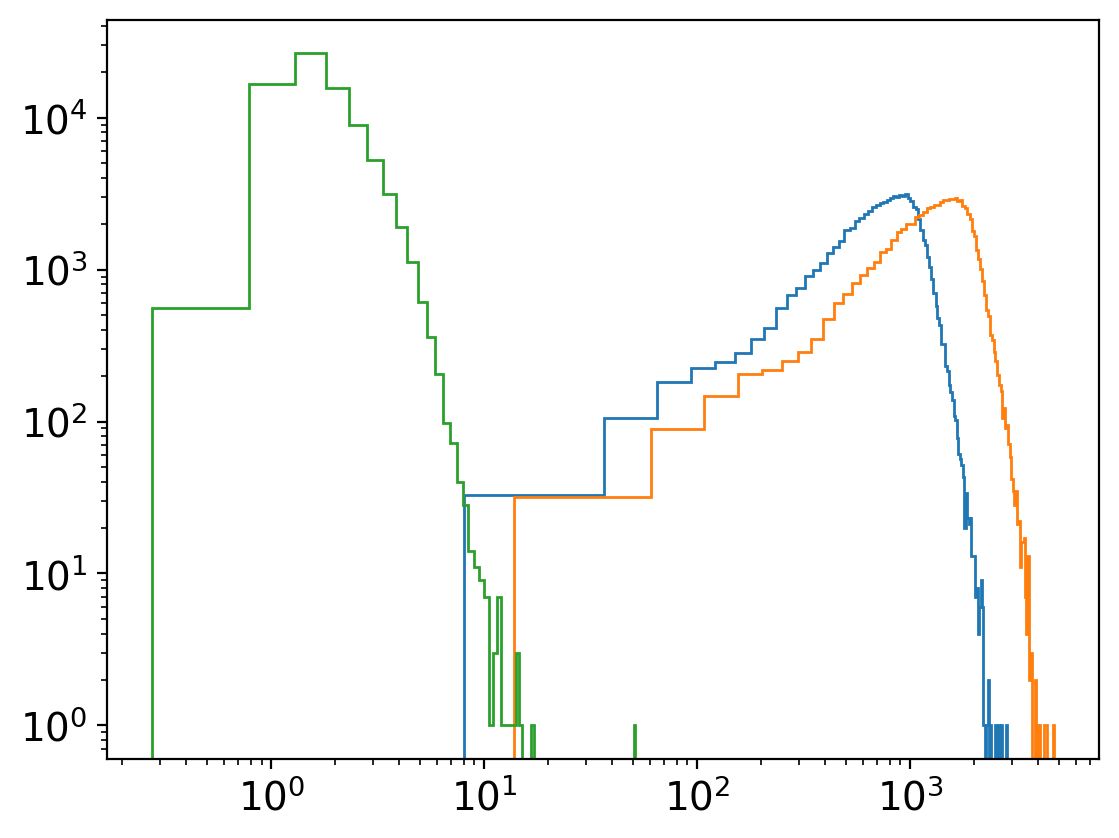

In [184]:
plt.hist(snr_rp, histtype='step', bins=100);
plt.hist(snr_rp_10, histtype='step', bins=100);
plt.hist(snr_rp_55, histtype='step', bins=100);
plt.xscale('log')
plt.yscale('log')

In [185]:

data_cont['df'] = data_cont['df'].assign(
    snr_bp=snr_bp, snr_bp10=snr_bp_10, snr_bp55=snr_bp_55, 
    snr_rp=snr_rp, snr_rp10=snr_rp_10, snr_rp55=snr_rp_55
)


In [186]:
data_cont['df'].columns

Index(['source_id', 'bp_coef', 'e_bp_coef', 'rp_coef', 'e_rp_coef',
       'GAIAEDR3_SOURCE_ID', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR',
       'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
       'GAIAEDR3_PHOT_G_MEAN_MAG', 'GAIAEDR3_PHOT_BP_MEAN_MAG',
       'GAIAEDR3_PHOT_RP_MEAN_MAG', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR',
       'M_H', 'M_H_ERR', 'ALPHA_M', 'ALPHA_M_ERR', 'W1mag', 'W2mag', 'W3mag',
       'W4mag', 'Jmag', 'Hmag', 'Kmag', 'e_W1mag', 'e_W2mag', 'qph_w1',
       'qph_w2', 'snr_bp', 'snr_rp', 'snr_bp10', 'snr_bp55', 'snr_rp10',
       'snr_rp55'],
      dtype='object')

In [188]:
data_cont.update(df=data_cont['df'])

np.save(data_dir+"ap17_wise_xpcont_cut.npy", data_cont)


# Norm andrae

In [57]:
norm_andrae = 10**((15.-data_cont['df']['GAIAEDR3_PHOT_G_MEAN_MAG'].values)*0.4)



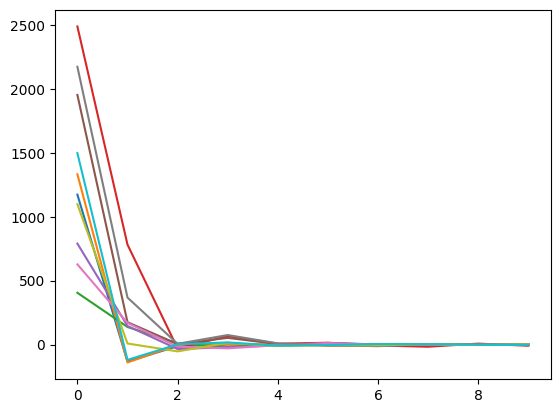

In [66]:
norm_bp_andrae = data_cont['bp_coef']/norm_andrae[:,None]
norm_rp_andrae = data_cont['rp_coef']/norm_andrae[:,None]

idx_lst = [0, 10, 100, 1000, 10000]


for i,idx in enumerate(idx_lst):
    plt.plot(norm_bp_andrae[idx,:x_len])
    plt.plot(norm_rp_andrae[idx,:x_len])

In [75]:
import math

log = np.vectorize(math.log)

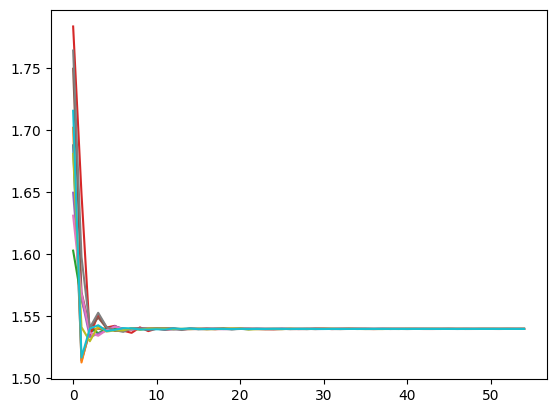

In [82]:
for i,idx in enumerate(idx_lst):
    plt.plot(log(norm_bp_andrae[idx,:55]+1200., 1e2))
    plt.plot(log(norm_rp_andrae[idx,:55]+1200., 1e2))

In [83]:
lgnorm_bp_andrae = log(norm_bp_andrae+1200., 1e2)
lgnorm_rp_andrae = log(norm_rp_andrae+1200., 1e2)


data_cont.update(
    lgnorm_bp_andrae=lgnorm_bp_andrae,
    lgnorm_rp_andrae=lgnorm_rp_andrae,
)

np.save(data_dir+"ap17_wise_xpcont_cut.npy", data_cont)



In [195]:
gdf = data_cont['df'].copy()

mask = (gdf['J']>-1) & (gdf['J']<20.) &\
        (gdf['H']>-0.) & (gdf['H']<15.) &\
        (gdf['K']>-1.) & (gdf['K']<20.) &\
        (gdf['M_H']>-3) & (gdf['M_H']<1) &\
        (gdf['TEFF']>4000) & (gdf['TEFF']<7000) & (gdf['LOGG']>0.5) & (gdf['LOGG']<5.5) &\
        (gdf['M_H']>-3) & (gdf['M_H']<1.0)   & (gdf['ALPHA_M']>-1) & (gdf['ALPHA_M']<1) &\
        (gdf['W1mag']>2) & (gdf['W1mag']<20.) &\
        (gdf['W2mag']>2) & (gdf['W2mag']<20.) &\
        (gdf['qph_w1']=='A') & (gdf['qph_w2']=='A')

print(gdf.shape, gdf[mask].shape)

(81309, 42) (70123, 42)


In [211]:

photo = gdf[['J','H','K']].values/gdf['J'].max()
norm_xp = np.c_[data_cont['norm_bp_coef'], data_cont['norm_rp_coef'], photo][mask]
andnorm_xp = np.c_[data_cont['lgnorm_bp_andrae'], data_cont['lgnorm_rp_andrae'], photo][mask]

labels =  gdf[['TEFF', 'LOGG', 'GAIAEDR3_PARALLAX', 'M_H','ALPHA_M']][mask].values
e_labels = gdf[['TEFF_ERR', 'LOGG_ERR', 'GAIAEDR3_PARALLAX_ERROR', 'M_H_ERR', 'ALPHA_M_ERR']][mask].values


source_id = gdf['source_id'][mask].values


norm = np.array([1e-2, 5., 15., 10., 50.]).astype(np.float32)
labels *= norm
e_labels *= norm

np.save(
    data_dir+"ap17_wise_xp_70123.npy", 
    {"norm_xp":norm_xp, "andnorm_xp":andnorm_xp, "labels":labels, "e_labels":e_labels, 
     "source_id":source_id}
)


print(norm_xp.shape, andnorm_xp.shape)
print(labels.shape, e_labels.shape)

(70123, 113) (70123, 113)
(70123, 5) (70123, 5)


In [210]:
labels

array([[61.6203   , 18.577803 , 19.477968 , -2.2150998,  2.403315 ],
       [50.312637 , 17.280659 , 20.795334 , -1.6008   ,  2.7852   ],
       [40.737698 ,  6.4075184,  5.4809093, -2.7033   ,  2.7654   ],
       ...,
       [40.743958 ,  5.5074444,  2.673623 , -5.7251   ,  2.8175   ],
       [42.910057 ,  9.119607 ,  3.7631419, -0.89454  ,  2.2372499],
       [43.113926 ,  8.6571455,  6.295656 , -4.9909   , 12.34475  ]],
      dtype=float32)

# Simple XGboost regression

In [255]:
import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

print(len(cat))
X = np.c_[data_cont['norm_bp_coef'], data_cont['norm_rp_coef']]
Y = np.c_[np.log10(data_cont['df'][['TEFF']].values), data_cont['df']['LOGG'].values]

# mask = np.isnan(Y)[:,0] & np.isnan(Y)[:,1]
# mask = (Y[:,0]>-1.) & (Y[:,0]<.) 
# & (Y[:,1]>-5.) & (Y[:,1]<1.)
# X, Y = X[mask], Y[mask]
print(X.shape, Y.shape)

# np.save(data_dir+"ap17_xp_post.npy", X, Y)


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.05, random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

88510
(82062, 110) (82062, 2)
(77958, 110) (4104, 110) (77958, 2) (4104, 2)


In [ ]:
reg = xgb.XGBRegressor(
    eval_metric=mean_squared_error, learning_rate=5e-1, n_jobs=32,
    reg_alpha=0.5, gamma=0.5,
)

reg.fit(X_train, y_train, 
        # eval_set=[(X_test, y_test)]
       )

RMSE (TEFF): 165.28
RMSE (LOGG): 0.22
Scatter (TEFF): 165.15
Scatter (LOGG): 0.22


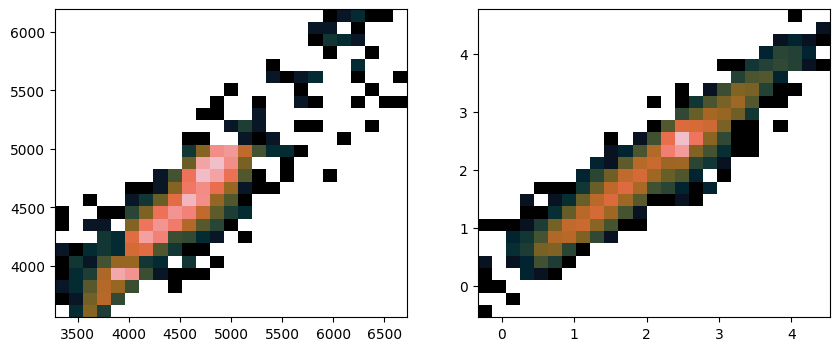

In [259]:
y_pred = reg.predict(X_test)

fig, axs = plt.subplots(1,2, figsize=(10,4))
ax1, ax2 = axs.ravel()

# ax1.scatter(y_train[:,0], y_pred[:,0], s=1)
# ax1.scatter(y_test[:,0], y_pred[:,0], s=1)
ax1.hist2d(10**y_test[:,0], 10**y_pred[:,0], norm=LogNorm(), bins=25, cmap=cmap);

# ax1.set_xlim([-1.2, 0.5]);
# ax1.set_ylim([-1.2, 0.5]);
# ax1.set_xlabel("[M/H]: APOGEE");
# ax1.set_ylabel("[M/H]: XP");


ax2.hist2d(y_test[:,1], y_pred[:,1], norm=LogNorm(), bins=25, cmap=cmap);

# ax2.set_xlim([-0.2, 0.4]);
# ax2.set_ylim([-0.2, 0.4]);
# ax2.set_ylabel(r"[$\alpha$/H]: XP");
# ax2.set_xlabel(r"[$\alpha$/H]: APOGEE");
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets)**2).mean())

def scatter(predictions, targets):
    return np.std(predictions - targets)


print("RMSE (TEFF): %.2f"%(rmse(10**y_pred[:,0], 10**y_test[:,0])))
print("RMSE (LOGG): %.2f"%(rmse(y_pred[:,1], y_test[:,1])))

print("Scatter (TEFF): %.2f"%(scatter(10**y_pred[:,0], 10**y_test[:,0])))
print("Scatter (LOGG): %.2f"%(scatter(y_pred[:,1], y_test[:,1])))